In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import scipy.stats as stats
import scipy.spatial as spatial

In [2]:
fig_dir = '../../paper/paper_figs/density'

In [3]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [4]:
r = 20

In [5]:
fig_count = 0

# PyFR analysis

In [6]:
e_corrs = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

## Compile pyfr locations and across correlations

In [7]:
pyfr_locs = plot.compile_df_locs(e_corrs['R'])
corr_pyfr_locs = np.atleast_2d(e_corrs['across'])

## Find locations within 10 

In [8]:
e_corrs['Density'] = plot.density_within_r(pyfr_locs, r)

In [9]:
e_corrs.head()

,across,within,Subject,R,Sample rate,Samples,Thresholded Electrodes,Sessions,Number thresholded,Total Time (hrs),Average Session Length (hrs),Total Electrodes,Proportion Thresholded,Density
0,0.845001,0.640388,31,[-63.64 -21.93 5.37],1024.0,14192640,10,7.0,42,3.850,0.550,52,0.808,0.026631
1,0.861388,0.640299,8,[-48.48 38.4 17.26],256.0,1586419,121,2.0,2,1.721,0.860,123,0.016,0.028071
2,0.665373,0.519872,13,[ 49.49 -34.7 35.17],256.0,2512896,44,4.0,79,2.727,0.682,123,0.642,0.015355
3,0.640677,0.445660,52,[ 65.66 -67.29 25.83],1000.0,14400000,82,2.0,16,4.000,2.000,98,0.163,0.011756
4,0.764366,0.504311,25,[-36.36 -1.81 59.76],256.0,458496,98,1.0,2,0.498,0.498,100,0.020,0.013916


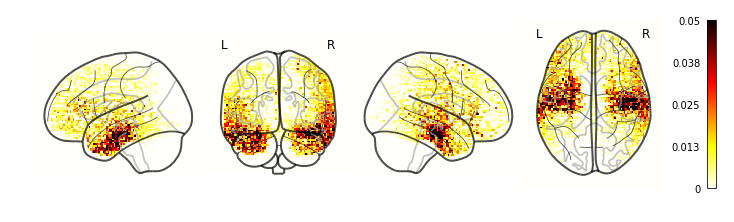

In [10]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(pyfr_locs, np.atleast_2d(plot.density_within_r(pyfr_locs, 20)), width=2, vox_size=2, outfile=outfile)

In [11]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(e_corrs['Density'], plot.r2z(e_corrs['across']))
print(rstat)

(-0.07110589810746443, 4.32665705810839e-06)


In [12]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(e_corrs['Density'], plot.r2z(e_corrs['within']))
print(rstat)

(0.025042921714367006, 0.10597743358180926)


<Figure size 1332x756 with 0 Axes>

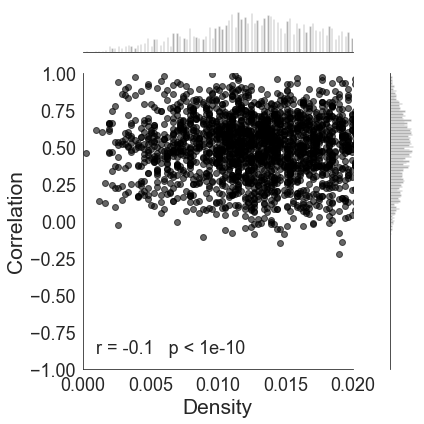

In [13]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_density(e_corrs, 'Density', 'across', outfile=outfile)

## Find density and correlation across vs within

In [14]:
grouped_results = e_corrs.groupby('Subject')['across','within'].mean()

pyfr_locs = plot.compile_df_locs(e_corrs['R'])
corr_pyfr_locs = np.atleast_2d(e_corrs['across'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_pyfr = np.array([])
density_within_pyfr = np.array([])

for s in grouped_results.index:


    other_locs = plot.compile_df_locs(e_corrs['R'][e_corrs['Subject'] != s])
    within_locs = plot.compile_df_locs(e_corrs['R'][e_corrs['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)

    bo_locs = []
    
    
    
    for l in plot.compile_df_locs(e_corrs['R'][e_corrs['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))

        density_across_pyfr = np.append(density_across_pyfr, np.divide(len(other_tree.query_ball_point(l, r)), other_locs.shape[0]))

        density_within_pyfr = np.append(density_within_pyfr, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(pyfr_locs, l)
        
        across_corr = e_corrs['across'].iloc[loc_in_R]
        within_corr = e_corrs['within'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_pyfr_df = pd.DataFrame()
density_pyfr_df['Correlation_Across'] = corr_across_subject
density_pyfr_df['Correlation_Within'] = corr_within_subject
density_pyfr_df['Density_Across'] = density_across_pyfr
density_pyfr_df['Density_Within'] = density_within_pyfr
density_pyfr_df['Subject'] = subj_by_subject

## negative correlation across density and recon accruacy

In [15]:
rstat = stats.pearsonr(density_pyfr_df['Density_Across'], plot.r2z(density_pyfr_df['Correlation_Across']))
print(rstat)

(-0.07695054034099691, 6.564746483933552e-07)


## but positive correlation across density and recon accruacy

In [16]:
rstat = stats.pearsonr(density_pyfr_df['Density_Within'], plot.r2z(density_pyfr_df['Correlation_Across']))
print(rstat)

(0.2048825327041378, 9.647539682547903e-41)


## slight positive within density and within correlation

In [17]:
rstat = stats.pearsonr(density_pyfr_df['Density_Within'], plot.r2z(density_pyfr_df['Correlation_Within']))
print(rstat)

(0.08808838004001908, 1.2239227154777536e-08)


## plot density for all

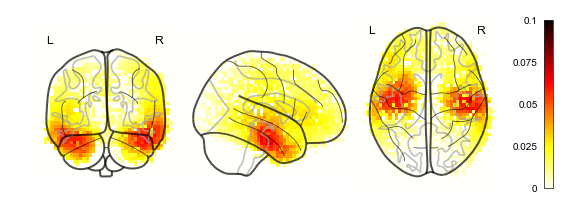

In [18]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')

plot.density_within_r_plot(pyfr_locs, r, vox_size=4, outfile=None)


## plot density across 

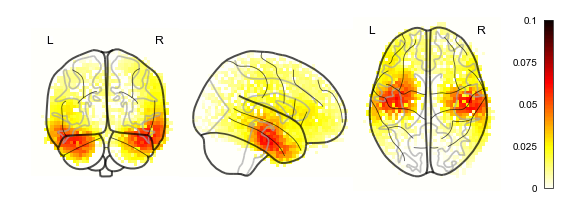

In [19]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_pyfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

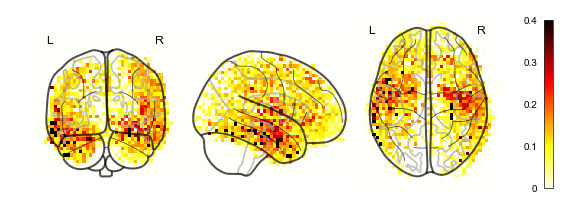

In [20]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_pyfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)

<Figure size 1332x756 with 0 Axes>

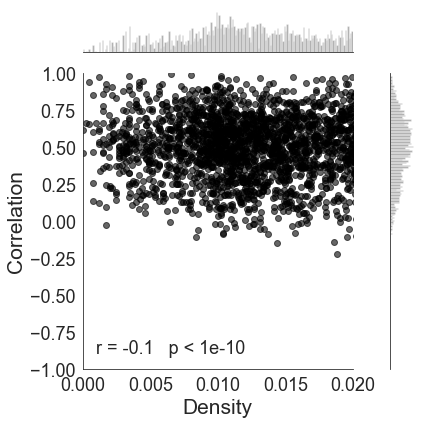

In [21]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_density(density_pyfr_df, 'Density_Across', 'Correlation_Across', outfile=outfile)

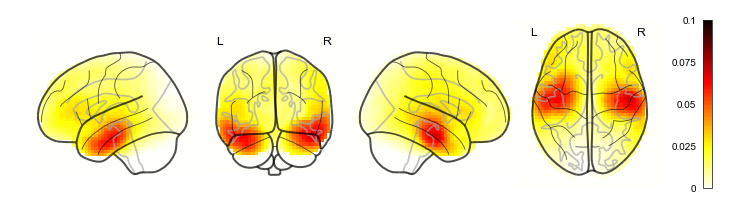

In [22]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.density_by_voxel_plot(pyfr_locs, r=20, vox_size=4, outfile=outfile)

In [23]:
density_by_vox_pyfr = plot.density_by_voxel(pyfr_locs, r=20, vox_size=4)

# RAM

In [24]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)

In [25]:
all_locs = plot.compile_df_locs(RAM_df['R'])
corr_all_locs = np.atleast_2d(RAM_df['W_a_w'])

In [26]:
RAM_df['Density'] = plot.density_within_r(all_locs, r)

In [27]:
rstat = stats.pearsonr(RAM_df['Density'], plot.r2z(RAM_df['W_a_w']))
print(rstat)

(-0.18147982308277585, 8.537160304258218e-25)


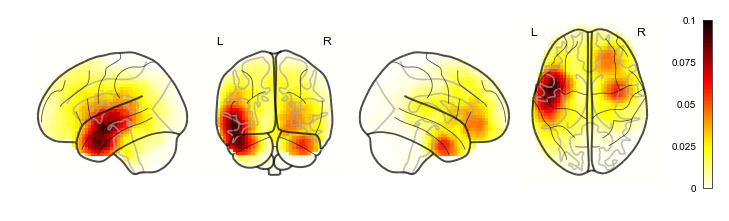

In [28]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.density_by_voxel_plot(all_locs, r=20, vox_size=4, outfile=outfile)

In [29]:
density_by_vox_all = plot.density_by_voxel(all_locs, r=20, vox_size=4)

In [30]:
density_by_vox_all.shape

(34686,)

In [31]:
density_locs_df = pd.DataFrame()
density_locs_df['RAM'] = density_by_vox_all
density_locs_df['PyFR'] = density_by_vox_pyfr
density_locs_df.dropna(inplace=True)

(0.5559080936024179, 0.0)


<Figure size 1332x1332 with 0 Axes>

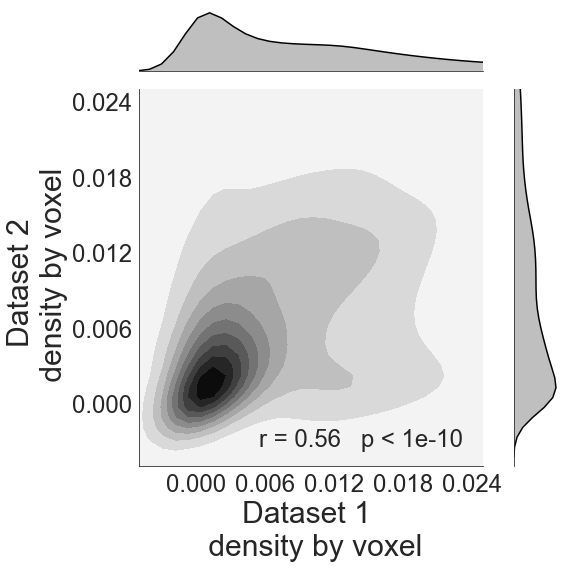

In [32]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
sns.set_style("white")
mybins=np.logspace(0,np.log(100),100)
g = (sns.jointplot('RAM', 'PyFR', density_locs_df, xlim=[-.005,.025],ylim=[-.005,.025], kind="kde", color='k', height=8).set_axis_labels('RAM', 'PyFR', fontsize=30))
ax = g.ax_joint

ax = g.ax_joint
left, width = .35, .5
bottom, height = .1, .5
rstat = stats.pearsonr(density_locs_df['RAM'], density_locs_df['PyFR'])
ax.text(left, bottom, 'r = ' + str(np.round(rstat[0],2)) + '   p < '+ str(10**-10),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize=24)
ax.set_xlabel("Dataset 1 \n density by voxel", fontsize=30)
ax.set_ylabel("Dataset 2 \n density by voxel", fontsize=30)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5))
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5))
plt.tight_layout()
print(rstat)

plt.savefig(outfile)


## FR

In [33]:
str_find = '_FR1'
str_find
FR_df = RAM_df[RAM_df['Experiment'].str.contains(str_find)]

In [34]:
fr_subject = np.array([])
fr_within = np.array([])
fr_across = np.array([])
fr_R = np.array([])
for i , item in enumerate(FR_df['Subject'].values):
    #print(item.split('_')[0])
    fr_subject = np.append(fr_subject, item)
    fr_within = np.append(fr_within, FR_df['W_w_w'].iloc[i])
    fr_across = np.append(fr_across, FR_df['W_a_w'].iloc[i])
    fr_R = np.append(fr_R, FR_df['R'].iloc[i])

In [35]:
corr_fr_df = pd.DataFrame()
corr_fr_df['Subject'] = fr_subject
corr_fr_df['W_w_w'] = fr_within
corr_fr_df['W_a_w'] = fr_across
corr_fr_df['R'] = fr_R

In [36]:
fr_locs = plot.compile_df_locs(corr_fr_df['R'])
corr_fr_locs = np.atleast_2d(corr_fr_df['W_a_w'])

In [37]:
density_fr = plot.density_within_r(fr_locs, r)

In [38]:
corr_fr_df['Density'] = density_fr

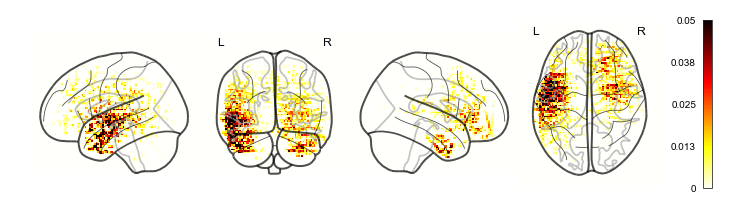

In [39]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(fr_locs, np.atleast_2d(density_fr), width=2, vox_size=2, outfile=outfile)

In [40]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_fr_df['Density'], plot.r2z(corr_fr_df['W_a_w']))
print(rstat)

(-0.17145965285059753, 4.739696007005744e-11)


In [41]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_fr_df['Density'], plot.r2z(corr_fr_df['W_w_w']))
print(rstat)

(0.0406660191413347, 0.12127987390597944)


<Figure size 1332x756 with 0 Axes>

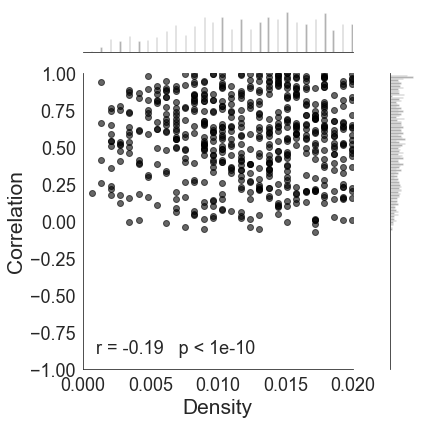

In [42]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_density(corr_fr_df, 'Density', 'W_a_w', outfile=outfile)

## Find density and correlation across vs within

In [43]:

grouped_results = corr_fr_df.groupby('Subject')['W_a_w','W_w_w'].mean()

pyfr_locs = plot.compile_df_locs(corr_fr_df['R'])
corr_fr_locs = np.atleast_2d(corr_fr_df['W_a_w'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_fr = np.array([])
density_within_fr = np.array([])

for s in grouped_results.index:


    other_locs = plot.compile_df_locs(corr_fr_df['R'][corr_fr_df['Subject'] != s])
    within_locs = plot.compile_df_locs(corr_fr_df['R'][corr_fr_df['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)


    bo_locs = []
    
    for l in plot.compile_df_locs(corr_fr_df['R'][corr_fr_df['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))
        density_across_fr = np.append(density_across_fr, np.divide(len(other_tree.query_ball_point(l, r)),  other_locs.shape[0]))
        density_within_fr = np.append(density_within_fr, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(fr_locs, l)
        
        across_corr = corr_fr_df['W_a_w'].iloc[loc_in_R]
        within_corr = corr_fr_df['W_w_w'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_fr_df = pd.DataFrame()
density_fr_df['Correlation_Across'] = corr_across_subject
density_fr_df['Correlation_Within'] = corr_within_subject
density_fr_df['Density_Across'] = density_across_fr
density_fr_df['Density_Within'] = density_within_fr
density_fr_df['Subject'] = subj_by_subject

In [44]:
rstat = stats.pearsonr(density_fr_df['Density_Across'], plot.r2z(density_fr_df['Correlation_Across']))
print(rstat)

(-0.23394999367170272, 1.628590971161974e-19)


In [45]:
rstat = stats.pearsonr(density_fr_df['Density_Within'], plot.r2z(density_fr_df['Correlation_Across']))
print(rstat)

(0.14214212757511002, 5.2924768382450217e-08)


In [46]:
rstat = stats.pearsonr(density_fr_df['Density_Within'], plot.r2z(density_fr_df['Correlation_Within']))
print(rstat)

(0.08591891695683347, 0.0010442596398817362)


## plot density for all

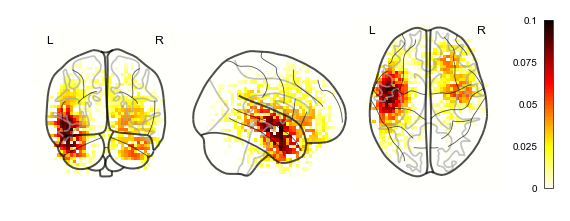

In [47]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')

plot.density_within_r_plot(fr_locs, r, vox_size=4, outfile=None)

## plot density across

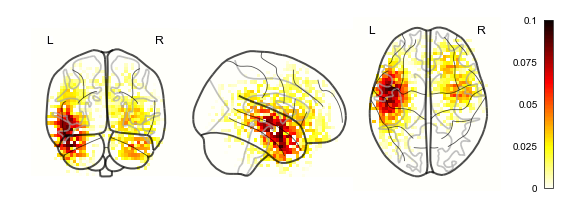

In [48]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_fr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

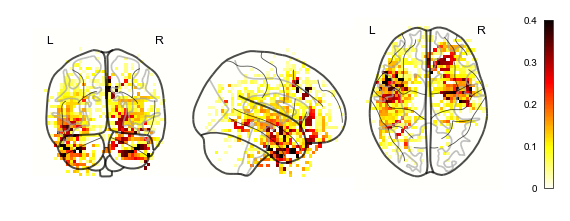

In [49]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_fr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)

<Figure size 1332x756 with 0 Axes>

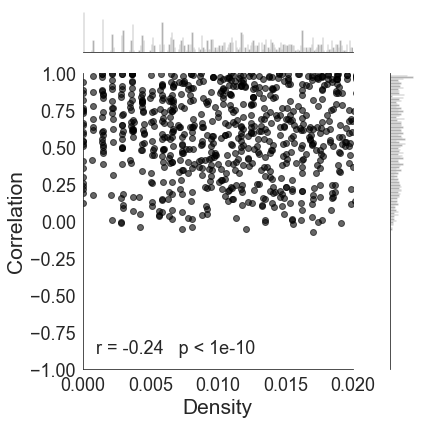

In [50]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_density(density_fr_df, 'Density_Across', 'Correlation_Across', outfile=outfile)

## CatFR

In [51]:
str_find = '_CatFR1'
str_find
CatFR_df = RAM_df[RAM_df['Experiment'].str.contains(str_find)]

In [52]:
catfr_subject = np.array([])
catfr_within = np.array([])
catfr_across = np.array([])
catfr_R = np.array([])
for i , item in enumerate(CatFR_df['Subject'].values):
    #print(item.split('_')[0])
    catfr_subject = np.append(catfr_subject, item)
    catfr_within = np.append(catfr_within, CatFR_df['W_w_w'].iloc[i])
    catfr_across = np.append(catfr_across, CatFR_df['W_a_w'].iloc[i])
    catfr_R = np.append(catfr_R, CatFR_df['R'].iloc[i])

In [53]:
corr_catfr_df = pd.DataFrame()
corr_catfr_df['Subject'] = catfr_subject
corr_catfr_df['W_w_w'] = catfr_within
corr_catfr_df['W_a_w'] = catfr_across
corr_catfr_df['R'] = catfr_R

In [54]:
catfr_locs = plot.compile_df_locs(corr_catfr_df['R'])
corr_catfr_locs = np.atleast_2d(corr_catfr_df['W_a_w'])

In [55]:
density_catfr = plot.density_within_r(catfr_locs, r)

In [56]:
corr_catfr_df['Density'] = density_catfr

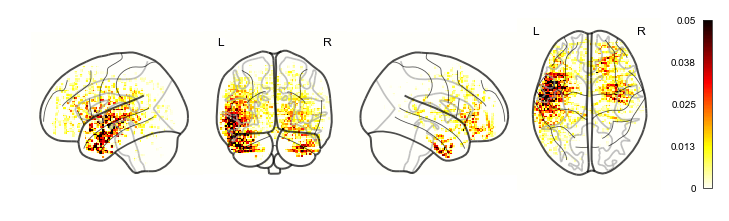

In [57]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.interp_density(catfr_locs, np.atleast_2d(density_catfr), width=2, vox_size=2, outfile=outfile)

In [58]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_catfr_df['Density'], plot.r2z(corr_catfr_df['W_a_w']))
print(rstat)

(-0.19872916397235418, 1.1809785617748465e-16)


In [59]:
### still same negative correlation with the new way 
rstat = stats.pearsonr(corr_catfr_df['Density'], plot.r2z(corr_catfr_df['W_w_w']))
print(rstat)

(0.16107146813750228, 2.2056623331660863e-11)


<Figure size 1332x756 with 0 Axes>

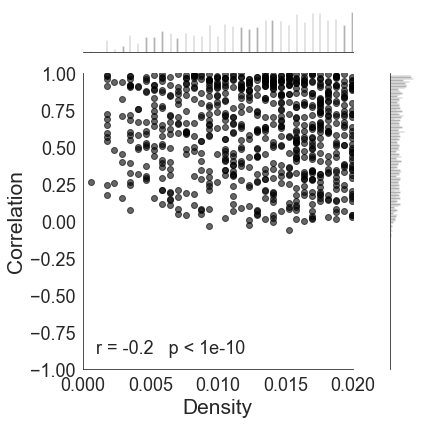

In [60]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_density(corr_catfr_df, 'Density', 'W_a_w', outfile=outfile)

In [61]:

grouped_results = corr_catfr_df.groupby('Subject')['W_a_w','W_w_w'].mean()

pyfr_locs = plot.compile_df_locs(corr_catfr_df['R'])
corr_catfr_locs = np.atleast_2d(corr_catfr_df['W_a_w'])

corr_across_subject = np.array([])
corr_within_subject = np.array([])
R_locs = []
bo_locs = []
subj_by_subject = np.array([])
density_across_catfr = np.array([])
density_within_catfr = np.array([])

for s in grouped_results.index:



    other_locs = plot.compile_df_locs(corr_catfr_df['R'][corr_catfr_df['Subject'] != s])
    within_locs = plot.compile_df_locs(corr_catfr_df['R'][corr_catfr_df['Subject'] == s])
    
    other_tree = spatial.cKDTree(other_locs)
    within_tree = spatial.cKDTree(within_locs)


    bo_locs = []
    
    for l in plot.compile_df_locs(corr_catfr_df['R'][corr_catfr_df['Subject'] == s]):
    
        if bo_locs == []:
            bo_locs = l 
        else:

            bo_locs = np.vstack((bo_locs, l))

        density_across_catfr = np.append(density_across_catfr, np.divide(len(other_tree.query_ball_point(l, r)), other_locs.shape[0]))
        density_within_catfr = np.append(density_within_catfr, np.divide(len(within_tree.query_ball_point(l, r)), within_locs.shape[0]))

        loc_in_R = se.helpers.get_rows(catfr_locs, l)
        
        across_corr = corr_catfr_df['W_a_w'].iloc[loc_in_R]
        within_corr = corr_catfr_df['W_w_w'].iloc[loc_in_R]
        
        corr_across_subject = np.append(corr_across_subject, across_corr)
        corr_within_subject = np.append(corr_within_subject, within_corr)

    subj_by_subject = np.append(subj_by_subject, np.array([str(s)]* np.shape(bo_locs)[0]))
    
    if R_locs == []:

        R_locs = bo_locs 

    else:

        R_locs = np.vstack((R_locs, bo_locs))




density_catfr_df = pd.DataFrame()
density_catfr_df['Correlation_Across'] = corr_across_subject
density_catfr_df['Correlation_Within'] = corr_within_subject
density_catfr_df['Density_Across'] = density_across_catfr
density_catfr_df['Density_Within'] = density_within_catfr
density_catfr_df['Subject'] = subj_by_subject

In [62]:
rstat = stats.pearsonr(density_catfr_df['Density_Across'], plot.r2z(density_catfr_df['Correlation_Across']))
print(rstat)

(-0.2482037521376066, 2.291403725443395e-25)


In [63]:
rstat = stats.pearsonr(density_catfr_df['Density_Within'], plot.r2z(density_catfr_df['Correlation_Across']))
print(rstat)

(0.1195259461354039, 7.38293677999542e-07)


In [64]:
rstat = stats.pearsonr(density_catfr_df['Density_Within'], plot.r2z(density_catfr_df['Correlation_Within']))
print(rstat)

(0.18622160048639524, 8.908922387166715e-15)


## plot density for all

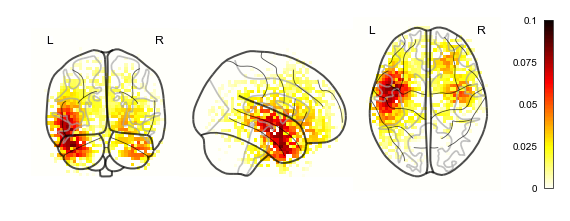

In [65]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')

plot.density_within_r_plot(catfr_locs, r, vox_size=4, outfile=None)

## plot density across

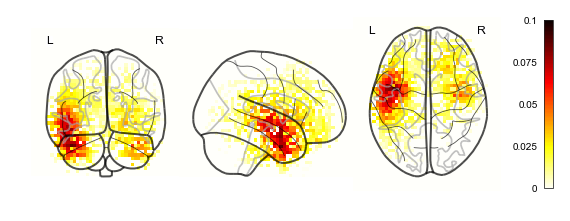

In [66]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_across_catfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.1, vmin=0)
plt.savefig(outfile)

## plot density within

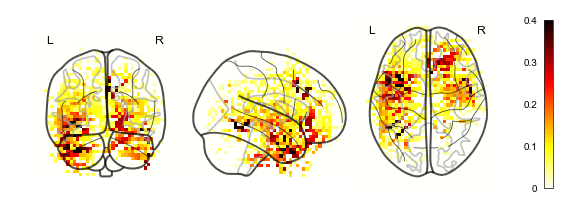

In [67]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
nii = se.load('std', vox_size=4)
full_locs = nii.get_locs().values
bo_nii = se.Brain(data=np.atleast_2d(density_within_catfr), locs=R_locs)
nii_bo = se.helpers._brain_to_nifti(bo_nii, nii)
ni_plt.plot_glass_brain(nii_bo, colorbar=True, threshold=None, vmax=.4, vmin=0)
plt.savefig(outfile)

<Figure size 1332x756 with 0 Axes>

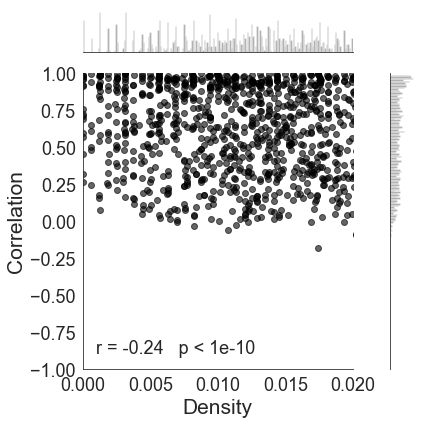

In [68]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_density(density_catfr_df, 'Density_Across', 'Correlation_Across', outfile=outfile)